# End-to-End DNN for ASR using CTC


## Introduction  

In this notebook, we build a deep neural network (DNN) that functions as part of an end-to-end automatic speech recognition (ASR) pipeline!  The completed pipeline will accept raw audio as input and return a predicted transcription of the spoken language.  The full pipeline is summarized in the figure below.

<img src="images/pipeline.png">

- **STEP 1** is a pre-processing step that converts raw audio to one of two feature representations (Spectrograms and MFCCs) that are commonly used for ASR. 
- **STEP 2** is an acoustic model which accepts audio features as input and returns a probability distribution over all potential transcriptions.  We design the acoustic model by using a combination of CNN and GRU.
- **STEP 3** the pipeline takes the output from the acoustic model, decodes the frames into a sequence of phonemes by using Connectionist Temporal Classification (CTC) loss function and then returns a predicted transcription.  

Use the links below to navigate the notebook:
- [The Data](#thedata)
- [**STEP 1**](#step1): Acoustic Features for Speech Recognition
- [**STEP 2**](#step2): Deep Neural Networks for Acoustic Modeling
    - [Model 0](#model0): RNN
    - [Model 1](#model1): RNN + TimeDistributed Dense
    - [Model 2](#model2): CNN + RNN + TimeDistributed Dense
    - [Model 3](#model3): Deeper RNN + TimeDistributed Dense
    - [Model 4](#model4): Bidirectional RNN + TimeDistributed Dense
    - [Compare the Models](#compare)
    - [Final Model Design](#final)
- [**STEP 3**](#step3): Obtain Predictions

<a id='thedata'></a>
## The Data

We begin by investigating the dataset that will be used to train and evaluate the pipeline.  [LibriSpeech](http://www.danielpovey.com/files/2015_icassp_librispeech.pdf) is a large corpus of English-read speech, designed for training and evaluating models for ASR.  The dataset contains 1000 hours of speech derived from audiobooks.  We will work with a small subset in this project, since larger-scale data would take a long while to train.  

In the code cells below, `vis_train_features` module is used to visualize a training example. The supplied argument `index=0` tells the module to extract the first example in the training set. We can change `index=0` to point to a different training example. The returned variables are:
- `vis_text` - transcribed text (label) for the training example.
- `vis_raw_audio` - raw audio waveform for the training example.
- `vis_mfcc_feature` - mel-frequency cepstral coefficients (MFCCs) for the training example.
- `vis_spectrogram_feature` - spectrogram for the training example. 
- `vis_audio_path` - the file path to the training example.

In [3]:
from data_generator import vis_train_features

# extract label and audio features for a single training example
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

There are 2023 total training examples.


The following code cell visualizes the audio waveform for the chosen example, along with the corresponding transcript.  We can also play the audio in the notebook!

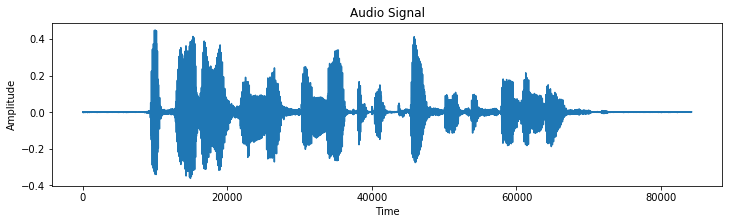

**Shape of Audio Signal** : (84231,)

**Transcript** : her father is a most remarkable person to say the least

In [2]:
from IPython.display import Markdown, display
from data_generator import vis_train_features, plot_raw_audio
from IPython.display import Audio
%matplotlib inline

# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

<a id='step1'></a>
## STEP 1: Acoustic Features for Speech Recognition

In this project, we don't use the raw audio waveform as input to the model.  Instead, we preprocess the raw audio and convert it to feature representation and use it as input to the acoustic model. Two feature representations, Spectrogram and MFCC, are explored.

Deep learning architectures that can accept raw audio input: 
[research paper](https://pdfs.semanticscholar.org/a566/cd4a8623d661a4931814d9dffc72ecbf63c4.pdf).

### Spectrograms

The first option for an audio feature representation is the [spectrogram](https://www.youtube.com/watch?v=_FatxGN3vAM). The code for calculating the spectrogram was borrowed from [Baidu's Deep Speech repository](https://github.com/baidu-research/ba-dls-deepspeech).  The implementation appears in the `utils.py` file in the repository.

The code returns the spectrogram as a 2D tensor, where the first (_vertical_) dimension indexes time, and the second (_horizontal_) dimension indexes frequency.  To speed the convergence of the algorithm, we have also normalized the spectrogram.  (You can see this quickly in the visualization below by noting that the mean value hovers around zero, and most entries in the tensor assume values close to zero.)

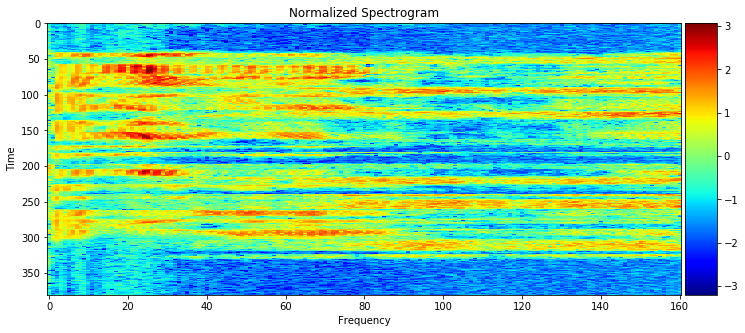

**Shape of Spectrogram** : (381, 161)

In [3]:
from data_generator import plot_spectrogram_feature

# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

### Mel-Frequency Cepstral Coefficients (MFCCs)

The second option for an audio feature representation is [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).  MFCCs are calculated using the python package -- [Python Speech Features](https://github.com/jameslyons/python_speech_features).  Just as with the spectrogram features, the MFCCs are normalized.

The main idea behind MFCC features is the same as spectrogram features: at each time window, the MFCC feature yields a feature vector that characterizes the sound within the window.  Note that the MFCC feature is much lower-dimensional than the spectrogram feature. This dimension reduction characteristics could help an acoustic model to avoid overfitting to the training dataset. 

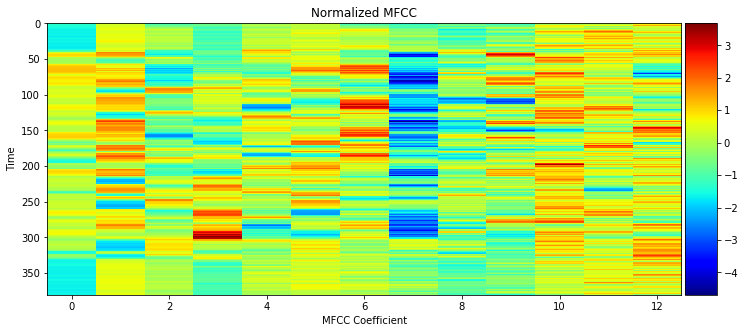

**Shape of MFCC** : (381, 13)

In [4]:
from data_generator import plot_mfcc_feature

# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

<a id='step2'></a>
## STEP 2: Deep Neural Networks for Acoustic Modeling

In this section, various neural network architectures are examined for acoustic modeling. We start off with a very simple RNN and gradually add model complexity. Based on the findings of each model, the goal is to construct an architecture that is designed to outperfrom all of the previous models.  

All models are specified in the `models.py` file.  After importing the `models.py` module, we can train the architectures in this notebook.

In [1]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 99% of GPU memory (feel free to change this)
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.99
set_session(tf.Session(config=config))

# watch for any changes in the models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import NN architectures for speech recognition
from models import *
# import function for training acoustic model
from train_utils import train_model
import time
from workspace_utils import active_session

Using TensorFlow backend.


<a id='model0'></a>
### Model 0: Simple RNN

Given their effectiveness in modeling sequential data, the first acoustic model we use is an GRU.  As shown in the figure below, the GRU take the time sequence of audio features as input.

<img src="images/simple_rnn.png" width="50%">

At each time step, the speaker pronounces one of 28 possible characters, including each of the 26 letters in the English alphabet, along with a space character (" "), and an apostrophe (').

The output of the RNN at each time step is a vector of probabilities with 29 entries, where the $i$-th entry encodes the probability that the $i$-th character is spoken in the time sequence.  (The extra 29th character is an empty "character" used to pad training examples within batches containing uneven lengths.)  `char_map.py` file in the repository shows how characters are mapped to indices in the probability vector. The figure below shows an equivalent, rolled depiction of the RNN that shows the output layer in greater detail. 

<img src="images/simple_rnn_unrolled.png" width="60%">

In [4]:
model_0 = simple_rnn_model(input_dim=161) # change to 13 if you would like to use MFCC features

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 29)          16617     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 16,617
Trainable params: 16,617
Non-trainable params: 0
_________________________________________________________________
None


We will train the acoustic model with the [CTC loss](http://www.cs.toronto.edu/~graves/icml_2006.pdf) criterion. CTC implementation details is in the `train_utils.py` file in the repository.

To train the architecture, use the `train_model` function within the `train_utils` module. The `train_model` function takes three **required** arguments:
- `input_to_softmax` - a Keras model instance.
- `pickle_path` - the name of the pickle file where the loss history will be saved.
- `save_model_path` - the name of the HDF5 file where the model will be saved.

There are several **optional** arguments that allow you to have more control over the training process.  
- `minibatch_size` - the size of the minibatches that are generated while training the model (default: `20`).
- `spectrogram` - Boolean value dictating whether spectrogram (`True`) or MFCC (`False`) features are used for training (default: `True`).
- `mfcc_dim` - the size of the feature dimension to use when generating MFCC features (default: `13`).
- `optimizer` - the Keras optimizer used to train the model (default: `SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)`).  
- `epochs` - the number of epochs to use to train the model (default: `20`).  If you choose to modify this parameter, make sure that it is *at least* 20.
- `verbose` - controls the verbosity of the training output in the `model.fit_generator` method (default: `1`).
- `sort_by_duration` - Boolean value dictating whether the training and validation sets are sorted by (increasing) duration before the start of the first epoch (default: `False`).

The `train_model` function defaults to using spectrogram features; if you choose to use these features, note that the acoustic model in `simple_rnn_model` should have `input_dim=161`.  Otherwise, if you choose to use MFCC features, the acoustic model should have `input_dim=13`.

__IMPORTANT NOTE:__ During the experiment, if we encounter gradient explosion in any of the model, we can apply gradient clipping (the `clipnorm` argument in the optimizer in 'train_utils.py') to alleviate the issue.  

In [7]:
train_model(input_to_softmax=model_0, 
            pickle_path='model_0.pickle', 
            save_model_path='model_0.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
101/101 [==============================] - 234s 2s/step - loss: 866.7142 - val_loss: 757.2101
Epoch 2/20
101/101 [==============================] - 239s 2s/step - loss: 778.5593 - val_loss: 755.2016
Epoch 3/20
101/101 [==============================] - 244s 2s/step - loss: 778.4119 - val_loss: 757.8475
Epoch 4/20
101/101 [==============================] - 244s 2s/step - loss: 777.9985 - val_loss: 755.8543
Epoch 5/20
101/101 [==============================] - 245s 2s/step - loss: 778.3309 - val_loss: 762.1433
Epoch 6/20
101/101 [==============================] - 244s 2s/step - loss: 778.1052 - val_loss: 759.5124
Epoch 7/20
101/101 [==============================] - 243s 2s/step - loss: 778.4275 - val_loss: 748.1821
Epoch 8/20
101/101 [==============================] - 245s 2s/step - loss: 778.2045 - val_loss: 760.0621
Epoch 9/20
101/101 [==============================] - 245s 2s/step - loss: 778.5959 - val_loss: 758.0870
Epoch 10/20
101/101 [==============================] - 

<a id='model1'></a>
### (IMPLEMENTATION) Model 1: RNN + TimeDistributed Dense

In this model, we will be adding two additional layers on top of the previous RNN model:
1. add [TimeDistributed](https://keras.io/layers/wrappers/) layer to find more complex patterns in the dataset, and
2. add [BatchNormalization](https://keras.io/layers/normalization/) layer to reduce training times.  (Reference: [batch normalization](https://arxiv.org/pdf/1510.01378.pdf))     

The unrolled snapshot of the architecture is depicted below.

<img src="images/rnn_model.png" width="60%">

The next figure shows an equivalent, rolled depiction of the RNN that shows the (`TimeDistrbuted`) dense and output layers in greater detail.  

<img src="images/rnn_model_unrolled.png" width="60%">

The first layer of the neural network is an `GRU` that takes the time sequence of audio features as input and batch normalize `GRU` outputs and then use `TimeDistributed` to apply a `Dense` layer to each of the time steps in the batch normalized `GRU` output.

In [2]:
model_1 = rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         217200    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 223,829
Trainable params: 223,429
Non-trainable params: 400
_________________________________________________________________
None


Execute the code cell below to train the neural network specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_1.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_1.pickle`.  

In [3]:
start = time.time()

train_model(input_to_softmax=model_1, 
            pickle_path='model_1.pickle', 
            save_model_path='model_1.h5',
            spectrogram=True) # change to False if you would to use MFCC features

duration = (time.time() - start)/60
print('Time elapsed: {:.3f} min'.format(duration))

Epoch 1/20
101/101 [==============================] - 251s 2s/step - loss: 305.6720 - val_loss: 242.9202
Epoch 2/20
101/101 [==============================] - 252s 2s/step - loss: 215.9827 - val_loss: 202.3424
Epoch 3/20
101/101 [==============================] - 253s 3s/step - loss: 192.3473 - val_loss: 182.1574
Epoch 4/20
101/101 [==============================] - 254s 3s/step - loss: 174.1952 - val_loss: 171.3927
Epoch 5/20
101/101 [==============================] - 254s 3s/step - loss: 161.9508 - val_loss: 158.8463
Epoch 6/20
101/101 [==============================] - 254s 3s/step - loss: 154.4190 - val_loss: 157.1870
Epoch 7/20
101/101 [==============================] - 255s 3s/step - loss: 148.5813 - val_loss: 155.5975
Epoch 8/20
101/101 [==============================] - 255s 3s/step - loss: 144.9733 - val_loss: 153.6693
Epoch 9/20
101/101 [==============================] - 252s 2s/step - loss: 142.1069 - val_loss: 150.7035
Epoch 10/20
101/101 [==============================] - 

<a id='model2'></a>
### (IMPLEMENTATION) Model 2: CNN + RNN + TimeDistributed Dense

This architecture adds an additional level of complexity, by introducing a [1D convolution layer](https://keras.io/layers/convolutional/#conv1d).  

<img src="images/cnn_rnn_model.png" width="100%">

If we want to use MFCC features, some Conv1D arguments will have to be tuned.  Note that the current architecture only supports values of `'same'` or `'valid'` for the `conv_border_mode` argument.

When tuning the parameters, be careful not to choose settings that make the convolutional layer overly small.  If the temporal length of the CNN layer is shorter than the length of the transcribed text label, the code will throw an error.

In this model we still apply batch normalization to the recurrent layer and provide the same `TimeDistributed` layer as before.

In [6]:
model_2 = cnn_rnn_model(input_dim=161, # change to 13 to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         240600    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Execute the code cell below to train the neural network specified in `input_to_softmax`.  After the model has finished training, the model is saved in the HDF5 file `model_2.h5`.  The loss history is saved in `model_2.pickle`.

In [7]:
start = time.time()

train_model(input_to_softmax=model_2, 
            pickle_path='model_2.pickle', 
            save_model_path='model_2.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

duration = (time.time() - start)/60
print('Time elapsed: {:.3f} min'.format(duration))

Epoch 1/20
101/101 [==============================] - 134s 1s/step - loss: 243.8711 - val_loss: 242.1192
Epoch 2/20
101/101 [==============================] - 132s 1s/step - loss: 188.0637 - val_loss: 172.5797
Epoch 3/20
101/101 [==============================] - 132s 1s/step - loss: 156.6950 - val_loss: 150.7730
Epoch 4/20
101/101 [==============================] - 131s 1s/step - loss: 141.2586 - val_loss: 143.6080
Epoch 5/20
101/101 [==============================] - 132s 1s/step - loss: 130.7556 - val_loss: 138.3537
Epoch 6/20
101/101 [==============================] - 130s 1s/step - loss: 122.5188 - val_loss: 133.4410
Epoch 7/20
101/101 [==============================] - 132s 1s/step - loss: 114.9218 - val_loss: 136.0345
Epoch 8/20
101/101 [==============================] - 131s 1s/step - loss: 108.7473 - val_loss: 130.1413
Epoch 9/20
101/101 [==============================] - 132s 1s/step - loss: 103.0772 - val_loss: 134.0327
Epoch 10/20
101/101 [==============================] - 

<a id='model3'></a>
### (IMPLEMENTATION) Model 3: Deeper RNN + TimeDistributed Dense

The models we have been implementing so far use a single recurrent layer. In this model, we would try a deeper neural network that utilizes a variable number of recurrent layers.  

The figure below shows the architecture that should be returned if `recur_layers=2`.  In the figure, the output sequence of the first recurrent layer is used as input for the next recurrent layer.

<img src="images/deep_rnn_model.png" width="80%">

In this model we still apply batch normalization after each of the recurrent layer and provide the same TimeDistributed layer as before.

In [2]:
model_3 = deep_rnn_model(input_dim=161, # change to 13 to use MFCC features
                         units=200,
                         recur_layers=2) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn1 (GRU)                   (None, None, 200)         217200    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 200)         800       
_________________________________________________________________
rnn2 (GRU)                   (None, None, 200)         240600    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Execute the code cell below to train the neural network specified in `input_to_softmax`.  After the model has finished training, the model is saved in the HDF5 file `model_3.h5`.  The loss history is saved in `model_3.pickle`.  

In [3]:
start = time.time()

train_model(input_to_softmax=model_3, 
            pickle_path='model_3.pickle', 
            save_model_path='model_3.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

duration = (time.time() - start)/60
print('Time elapsed: {:.3f} min'.format(duration))




Epoch 1/20
101/101 [==============================] - 397s 4s/step - loss: 280.7077 - val_loss: 263.1720
Epoch 2/20
101/101 [==============================] - 408s 4s/step - loss: 233.5279 - val_loss: 237.5078
Epoch 3/20
101/101 [==============================] - 411s 4s/step - loss: 213.6916 - val_loss: 217.9164
Epoch 4/20
101/101 [==============================] - 408s 4s/step - loss: 178.0276 - val_loss: 171.1443
Epoch 5/20
101/101 [==============================] - 409s 4s/step - loss: 156.6936 - val_loss: 155.0629
Epoch 6/20
101/101 [==============================] - 405s 4s/step - loss: 145.3878 - val_loss: 149.7741
Epoch 7/20
101/101 [==============================] - 406s 4s/step - loss: 138.2544 - val_loss: 147.0338
Epoch 8/20
101/101 [==============================] - 405s 4s/step - loss: 134.0926 - val_loss: 142.3339
Epoch 9/20
101/101 [==============================] - 405s 4s/step - loss: 129.6130 - val_loss: 136.7093
Epoch 10/20
101/101 [==============================] - 

<a id='model4'></a>
### (IMPLEMENTATION) Model 4: Bidirectional RNN + TimeDistributed Dense

In this model, we will specify an architecture that uses a single bidirectional RNN layer, before a (`TimeDistributed`) dense layer.  The added value of a bidirectional RNN is described well in [this paper](http://www.cs.toronto.edu/~hinton/absps/DRNN_speech.pdf).
> One shortcoming of conventional RNNs is that they are only able to make use of previous context. In speech recognition, where whole utterances are transcribed at once, there is no reason not to exploit future context as well.  Bidirectional RNNs do this by processing the data in both directions with two separate hidden layers which are then fed forwards to the same output layer.

<img src="images/bidirectional_rnn_model.png" width="80%">

In [2]:
model_4 = bidirectional_rnn_model(input_dim=161, # change to 13 to use MFCC features
                                  units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         434400    
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 446,029
Trainable params: 446,029
Non-trainable params: 0
_________________________________________________________________
None


Execute the code cell below to train the neural network specified in `input_to_softmax`.  After the model has finished training, the model is saved in the HDF5 file `model_4.h5`.  The loss history is saved `model_4.pickle`.

In [3]:
with active_session():
    
    start = time.time()
    train_model(input_to_softmax=model_4, 
                pickle_path='model_4.pickle', 
                save_model_path='model_4.h5', 
                spectrogram=True) # change to False if you would like to use MFCC features

    duration = (time.time() - start)/60
    print('Time elapsed: {:.3f} min'.format(duration))

Epoch 1/20
101/101 [==============================] - 377s 4s/step - loss: 302.7381 - val_loss: 253.9574
Epoch 2/20
101/101 [==============================] - 386s 4s/step - loss: 249.5247 - val_loss: 237.1388
Epoch 3/20
101/101 [==============================] - 384s 4s/step - loss: 239.7681 - val_loss: 224.9577
Epoch 4/20
101/101 [==============================] - 386s 4s/step - loss: 224.8747 - val_loss: 208.5428
Epoch 5/20
101/101 [==============================] - 385s 4s/step - loss: 204.5903 - val_loss: 194.3021
Epoch 6/20
101/101 [==============================] - 385s 4s/step - loss: 193.8482 - val_loss: 186.0693
Epoch 7/20
101/101 [==============================] - 385s 4s/step - loss: 183.9784 - val_loss: 176.5571
Epoch 8/20
101/101 [==============================] - 385s 4s/step - loss: 175.1845 - val_loss: 174.5843
Epoch 9/20
101/101 [==============================] - 390s 4s/step - loss: 167.7759 - val_loss: 164.3383
Epoch 10/20
101/101 [==============================] - 

<a id='compare'></a>
### Compare the Models

To evaluate the performance of the drafted RNN models.  The training and validation loss are plotted for each model.

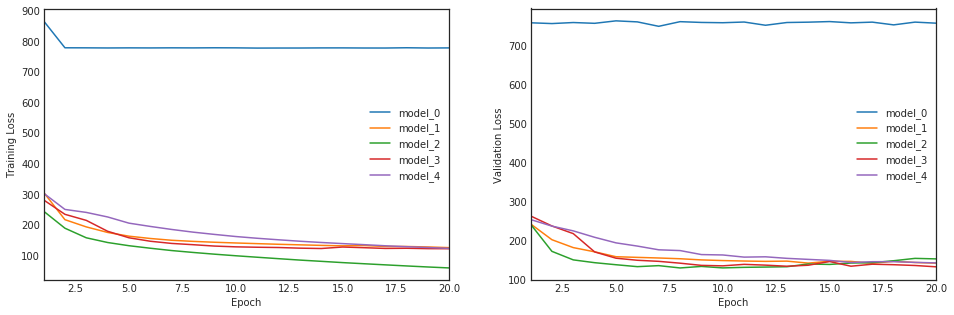

In [2]:
from glob import glob
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/*.pickle"))
# extract the name of each model
model_names = [item[8:-7] for item in all_pickles]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

From the model comparison plots above, it is observed that the simple RNN model (model_0) performs the worst while all other more sophisticated models demonstrate comparable performace. 
Among all competitive models (model_1 ~ model_4), the CNN+RNN model (model_2) has the best performance in the training set; however, it seems to suffer overfitting in the validation set as its validation loss is much higher than its training loss.

Each competitive model has its advantage: 

CNNs are excellent for image feature extractions. Since audio data can be represented as frequency vs time in spectrogram or MFCC coefficient vs time in MFCC, spectrogram and MFCC can be thought of as an image and can apply CNN on top of RNN for better performance.

RNNs are good at temporal modeling, bidirectional RNNs update weights learned using both forward (past information) and backward (future information) directions to capture the context better, and deep RNNs are appropriate for learning features from data in an incremental manner. 

These competitive models also have some structures in common that made them perform better than the simple RNN model. They all utilize time distributed dense layer which keeps one-to-one relations on input and output, so that the RNN output doesn't need to get flatten to randomly interact between different timesteps. This helps finding patterns in a temporal data like the speech data we have. The competitive models also implement batch normalization, which uses mini-batch statistics to standardize features, to expedite convergence of model training. 

<a id='final'></a>
### (IMPLEMENTATION) Final Model Design

Now that we've tried out many models, we want to incorporate the explored layers above into a deeper architecture. Since overfitting is an issue when implementing CNN with RNN, we will add [variational inference based dropout technique](http://arxiv.org/abs/1512.05287) in our GRU models.

CNN seems to enhance model performance, so we will include it in the final model. Further more, we may get better results by working with [dilated convolutions](https://arxiv.org/abs/1609.03499).
For an example of a speech-to-text system that makes use of dilated convolutions, check out this GitHub [repository](https://github.com/buriburisuri/speech-to-text-wavenet).  

So far, we have experimented with a single bidirectional RNN layer.  In the final model, we'd consider stacking the bidirectional layers, to produce a [deep bidirectional RNN](https://www.cs.toronto.edu/~graves/asru_2013.pdf)!

All models that we specify in this repository should have `output_length` defined as an attribute.  This attribute is a lambda function that maps the (temporal) length of the input acoustic features to the (temporal) length of the output softmax layer.  This function is used in the computation of CTC loss; to see this, look at the `add_ctc_loss` function in `train_utils.py`.  To see where the `output_length` attribute is defined for the models in the code, take a look at the `models.py` file.  
Note that in the case of models that use purely recurrent layers, the lambda function is the identity function, as the recurrent layers do not modify the (temporal) length of their input tensors.  However, convolutional layers are more complicated and require a specialized function (`cnn_output_length` in `models.py`) to determine the temporal length of their output.

In [2]:
# specify the model
model_end = final_model(input_dim=161,
                        units=200, recur_layers=3,
                        filters=128,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid')

/home/workspace/sample_models.py:163: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(200, activation="relu", return_sequences=True, implementation=2, name="biGRU", dropout=0.3, recurrent_dropout=0.0)`
  return_sequences=True, implementation=2, name='biGRU'))(inp)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         226816    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 128)         512       
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         394800    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 400)         1600      
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 400)         721200    
__________

Execute the code cell below to train the neural network specified in `input_to_softmax`.  After the model has finished training, the model is saved in the HDF5 file `model_end.h5`.  The loss history is saved in `model_end.pickle`.  

In [3]:
with active_session():
    
    start = time.time()
    train_model(input_to_softmax=model_end, 
                pickle_path='model_end.pickle', 
                save_model_path='model_end.h5', 
                spectrogram=True) # change to False if you would like to use MFCC features

    duration = (time.time() - start)/60
    print('Time elapsed: {:.3f} min'.format(duration))

Epoch 1/50
101/101 [==============================] - 595s 6s/step - loss: 259.5449 - val_loss: 229.6952
Epoch 2/50
101/101 [==============================] - 607s 6s/step - loss: 211.6922 - val_loss: 188.2438
Epoch 3/50
101/101 [==============================] - 590s 6s/step - loss: 184.3617 - val_loss: 165.4333
Epoch 4/50
101/101 [==============================] - 591s 6s/step - loss: 165.2488 - val_loss: 147.4560
Epoch 5/50
101/101 [==============================] - 593s 6s/step - loss: 150.8485 - val_loss: 143.0617
Epoch 6/50
101/101 [==============================] - 598s 6s/step - loss: 141.1054 - val_loss: 135.4028
Epoch 7/50
101/101 [==============================] - 598s 6s/step - loss: 133.6725 - val_loss: 126.2064
Epoch 8/50
101/101 [==============================] - 595s 6s/step - loss: 127.4058 - val_loss: 123.6761
Epoch 9/50
101/101 [==============================] - 595s 6s/step - loss: 122.6496 - val_loss: 121.1931
Epoch 10/50
101/101 [==============================] - 

### Final Model Architecture
Since all of the competitive models (model_1 to model_4) perform quite similarly and each model has its unique modeling capabilities. The final model tries to take advantage of the complementarity of these models.

The final model combines the previous models (model_1 to model_4) into one unified architecture, which I called CBiDNN.

CBiDNN architecture consists of two main components: the convolutional
layer and the bidirectional-deep recurrent layer.

The convolution network consists of one 1D convolution layer, dropout and batch normalization. 
1D conv uses kernel size of 11 with a stride of 2 and 128 filters followed by 20% dropout and batch normalization. The filter size and dropout ratio are tuned.   

The RNN network consumes CNN outputs. The RNN block consists of three layers of bidirectional GRUs using relu nonlinearity. 30% of dropout is applied in each input gates to alleviate overfitting, and each layer of bidirectional RNN is followed by batch normalization to speed up training. 

Finally, the RNN output is fed into the time distributed dense layer with softmax for prediction.

The model training was early stopped at epoch 38 with training loss: 63.3920 and val_loss: 92.7198. 

Note: The Keras version used at time of training did not support `restore_best_weights` feature in earlystopping; therefore, the model weights were obtained from the last step of training rather than best monitored values.


<a id='step3'></a>
## STEP 3: Obtain Predictions


In [ ]:
import numpy as np
from data_generator import AudioGenerator
from keras import backend as K
from utils import int_sequence_to_text
from IPython.display import Audio

def get_predictions(index, partition, input_to_softmax, model_path):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator()
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the true and predicted transcriptions
    print('-'*80)
    Audio(audio_path)
    print('True transcription:\n' + '\n' + transcr)
    print('-'*80)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)

Run code cell below to obtain the transcription predicted by the final model for the first example in the training dataset.

In [3]:
get_predictions(index=0, 
                partition='train',
                input_to_softmax=final_model(input_dim=161,
                        units=200, recur_layers=3,
                        filters=128,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid'), 
                model_path='results/model_end.h5')

/home/workspace/sample_models.py:163: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(200, activation="relu", return_sequences=True, implementation=2, name="biGRU", dropout=0.3, recurrent_dropout=0.0)`
  return_sequences=True, implementation=2, name='biGRU'))(inp)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         226816    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 128)         512       
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         394800    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 400)         1600      
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 400)         721200    
__________

Run the next code cell to visualize the model's prediction for the first example in the validation dataset.

In [4]:
get_predictions(index=0, 
                partition='validation',
                input_to_softmax=final_model(input_dim=161,
                        units=200, recur_layers=3,
                        filters=128,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid'), 
                model_path='results/model_end.h5')

/home/workspace/sample_models.py:163: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(200, activation="relu", return_sequences=True, implementation=2, name="biGRU", dropout=0.3, recurrent_dropout=0.0)`
  return_sequences=True, implementation=2, name='biGRU'))(inp)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         226816    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 128)         512       
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         394800    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 400)         1600      
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 400)         721200    
__________

## Next steps for further improvement
Besides using more data to train the model, there are two methods that we can try to improve model performance.
1. One standard way to improve the results of the decoder is to incorporate a `language model (LM)`. The job of a LM is to inject the language knowledge into the words-to-text step in ASR, providing another layer of processing between words and text to solve ambiguities in spelling and context. Google AI Language recently published [BERT]( https://arxiv.org/abs/1810.04805) which applies the bidirectional training of `Transformer`, an attention model, to language modelling. BERT seems like a promising approach to try.

2. Alternately, we can try two other popular ASR architectures:
    - attention-based `Seq2Seq` models which powered [Listend-Attend-Spell](https://arxiv.org/abs/1508.01211)
    - `RNN-Transducer`, which can be thought of as an encoder-decoder model, assumes the alignment between input and output tokens is local and monotonic. RNN-Transducer implementation has shown success without LMs.
    
Final words about LM: [Deep Speech 3](http://research.baidu.com/Blog/index-view?id=90)
>Language models are vital to speech recognition because language models can be trained rapidly on much larger datasets, and secondly language models can be used for specializing the speech recognition model according to context (user, geography, application etc.) without a labeled speech corpus for each context. The latter is especially vital in a production speech recognition system.